Fetching data from World Bank API...
Successfully fetched 340 data points for 10 countries

Data Summary:
Countries: Brazil, China, France, Germany, India, Italy, Japan, Romania, United Kingdom, United States
Year range: 1990 - 2023
Total data points: 340

Sample data:
   country country_code  year  gdp_per_capita_ppp
33  Brazil          BRA  1990        12633.288457
32  Brazil          BRA  1991        12546.560502
31  Brazil          BRA  1992        12271.978849
30  Brazil          BRA  1993        12669.428722
29  Brazil          BRA  1994        13202.930802
28  Brazil          BRA  1995        13550.439375
27  Brazil          BRA  1996        13641.629601
26  Brazil          BRA  1997        13896.624991
25  Brazil          BRA  1998        13737.702644
24  Brazil          BRA  1999        13602.413708


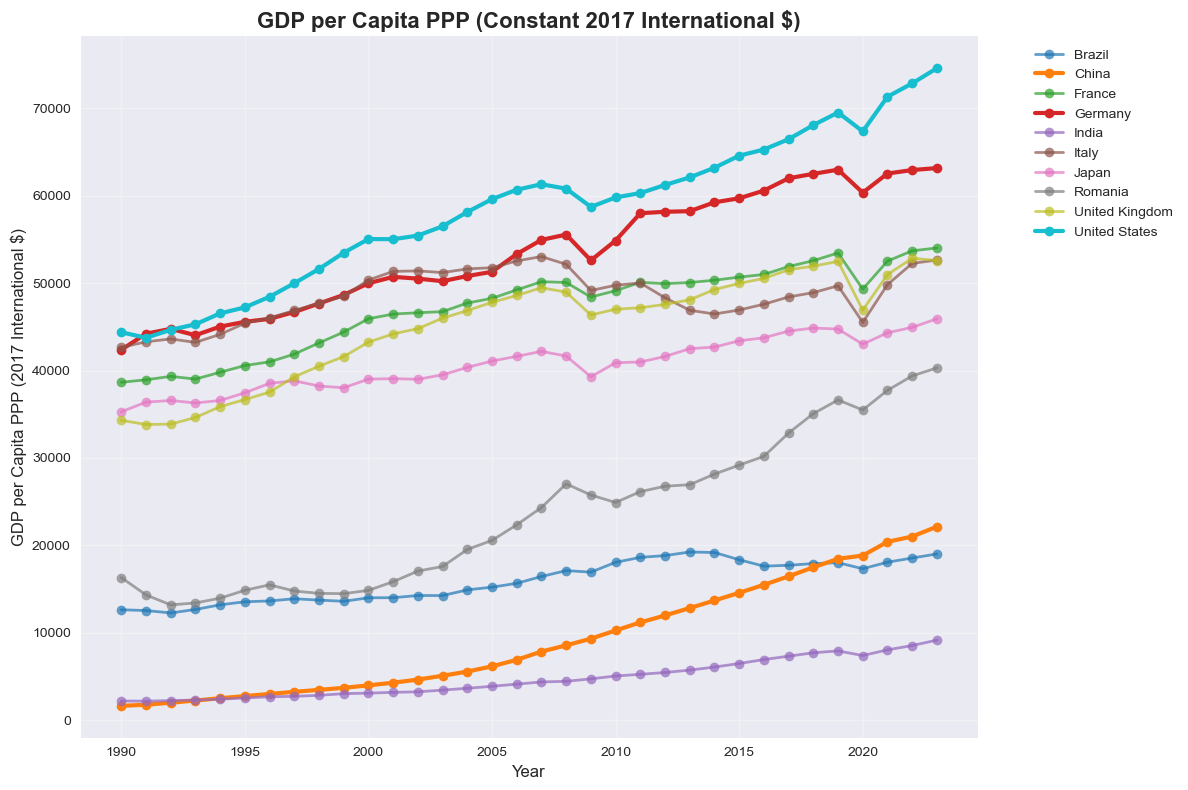

No data for requested year, using 2023 instead


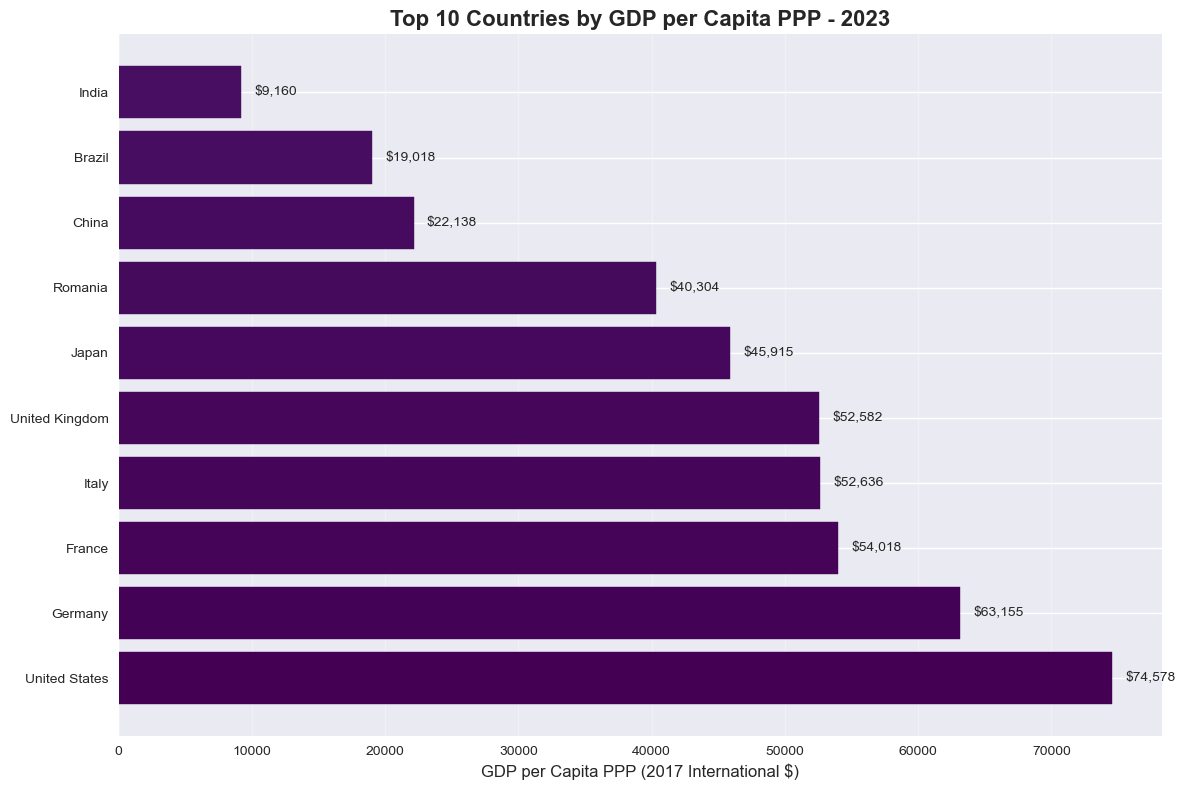


Data saved to 'worldbank_gdp_data.csv'


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class WorldBankDataFetcher:
    def __init__(self):
        self.base_url = "https://api.worldbank.org/v2"
        
    def get_gdp_data(self, countries=None, start_year=1990, end_year=2025):
        """
        Fetch GDP per capita PPP data from World Bank API
        
        Parameters:
        countries: list of country codes (e.g., ['US', 'CN', 'DE']) or None for all
        start_year: starting year for data
        end_year: ending year for data
        """
        
        # If no countries specified, use a selection of major economies
        if countries is None:
            countries = ['US', 'CN', 'JP', 'DE', 'IN', 'GB', 'FR', 'BR', 'IT', 'ROU']
        
        country_str = ';'.join(countries)
        
        # World Bank API endpoint
        url = f"{self.base_url}/country/{country_str}/indicator/NY.GDP.PCAP.PP.KD"
        
        params = {
            'format': 'json',
            'date': f'{start_year}:{end_year}',
            'per_page': 1000,
            'page': 1
        }
        
        print(f"Fetching data from World Bank API...")
        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            raise Exception(f"API request failed with status code: {response.status_code}")
        
        data = response.json()
        
        # The API returns metadata in first element, actual data in second
        if len(data) < 2:
            raise Exception("No data returned from API")
        
        records = data[1]
        
        if not records:
            raise Exception("No records found in the data")
        
        # Convert to DataFrame
        df_list = []
        for record in records:
            if record['value'] is not None:  # Skip null values
                df_list.append({
                    'country': record['country']['value'],
                    'country_code': record['countryiso3code'],
                    'year': int(record['date']),
                    'gdp_per_capita_ppp': float(record['value'])
                })
        
        df = pd.DataFrame(df_list)
        df = df.sort_values(['country', 'year'])
        
        print(f"Successfully fetched {len(df)} data points for {df['country'].nunique()} countries")
        return df

    def create_time_series_plot(self, df, countries_to_highlight=None, figsize=(12, 8)):
        """Create a time series plot of GDP per capita PPP"""
        
        plt.figure(figsize=figsize)
        
        # Set style
        plt.style.use('seaborn-v0_8')
        colors = plt.cm.tab10(range(len(df['country'].unique())))
        
        for i, country in enumerate(df['country'].unique()):
            country_data = df[df['country'] == country]
            
            # Highlight specific countries if specified
            if countries_to_highlight and country in countries_to_highlight:
                plt.plot(country_data['year'], country_data['gdp_per_capita_ppp'], 
                        marker='o', linewidth=3, label=country, color=colors[i])
            else:
                plt.plot(country_data['year'], country_data['gdp_per_capita_ppp'], 
                        marker='o', linewidth=2, alpha=0.7, label=country, color=colors[i])
        
        plt.title('GDP per Capita PPP (Constant 2017 International $)', fontsize=16, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('GDP per Capita PPP (2017 International $)', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt

    def create_comparison_plot(self, df, year=2025, top_n=15):
        """Create a bar plot comparing countries for a specific year"""
        
        # Get data for specific year
        year_data = df[df['year'] == year].copy()
        
        if year_data.empty:
            # Find the most recent year available
            year = df['year'].max()
            year_data = df[df['year'] == year].copy()
            print(f"No data for requested year, using {year} instead")
        
        # Sort and get top N countries
        year_data = year_data.sort_values('gdp_per_capita_ppp', ascending=False).head(top_n)
        
        plt.figure(figsize=(12, 8))
        
        bars = plt.barh(range(len(year_data)), year_data['gdp_per_capita_ppp'])
        
        # Color bars with gradient
        colors = plt.cm.viridis(range(len(year_data)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        plt.yticks(range(len(year_data)), year_data['country'])
        plt.xlabel('GDP per Capita PPP (2017 International $)', fontsize=12)
        plt.title(f'Top {top_n} Countries by GDP per Capita PPP - {year}', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, (idx, row) in enumerate(year_data.iterrows()):
            plt.text(row['gdp_per_capita_ppp'] + 1000, i, f'${row["gdp_per_capita_ppp"]:,.0f}', 
                    va='center', fontsize=10)
        
        plt.tight_layout()
        return plt

# Main execution
if __name__ == "__main__":
    # Initialize the data fetcher
    fetcher = WorldBankDataFetcher()
    
    # Example 1: Get data for specific countries
    countries_of_interest = ['US', 'CN', 'JP', 'DE', 'IN', 'GB', 'FR', 'BR', 'IT', 'ROU']
    
    try:
        # Fetch the data
        gdp_data = fetcher.get_gdp_data(
            countries=countries_of_interest, 
            start_year=1990, 
            end_year=2025
        )
        
        # Display basic statistics
        print("\nData Summary:")
        print(f"Countries: {', '.join(gdp_data['country'].unique())}")
        print(f"Year range: {gdp_data['year'].min()} - {gdp_data['year'].max()}")
        print(f"Total data points: {len(gdp_data)}")
        
        # Show sample data
        print("\nSample data:")
        print(gdp_data.head(10))
        
        # Create time series plot
        plt1 = fetcher.create_time_series_plot(
            gdp_data, 
            countries_to_highlight=['United States', 'China', 'Germany']
        )
        plt1.show()
        
        # Create comparison plot for most recent year
        plt2 = fetcher.create_comparison_plot(gdp_data, top_n=10)
        plt2.show()
        
        # Save data to CSV for further analysis
        gdp_data.to_csv(r'C:\Users\Svitlana\OneDrive\RoFacts\mvp\Data_drafts\gdp_per_capita.csv', index=False)
        print(f"\nData saved to 'gdp_per_capita.csv'")
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please check your internet connection and try again.")

# Additional utility functions
def get_country_codes():
    """Helper function to get available country codes"""
    url = "https://api.worldbank.org/v2/country?format=json&per_page=300"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        countries = data[1]
        return {country['name']: country['id'] for country in countries 
                if country['capitalCity']}  # Filter out regions/aggregates
    return {}

def analyze_growth_rates(df):
    """Calculate and display growth rates for each country"""
    growth_data = []
    
    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')
        if len(country_data) >= 2:
            first_value = country_data.iloc[0]['gdp_per_capita_ppp']
            last_value = country_data.iloc[-1]['gdp_per_capita_ppp']
            years = country_data.iloc[-1]['year'] - country_data.iloc[0]['year']
            
            # Calculate compound annual growth rate (CAGR)
            cagr = ((last_value / first_value) ** (1/years) - 1) * 100
            
            growth_data.append({
                'country': country,
                'start_year': country_data.iloc[0]['year'],
                'end_year': country_data.iloc[-1]['year'],
                'start_gdp': first_value,
                'end_gdp': last_value,
                'cagr_percent': cagr
            })
    
    return pd.DataFrame(growth_data).sort_values('cagr_percent', ascending=False)